## InceptionV3 felhasználásával
Előre tanított modelleket lekérjük a TensorFlowHub-ról.

### Csomagok Betöltése

In [1]:
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.data import AUTOTUNE
from tensorflow import keras
from tensorflow.keras import layers
import json

### Oxford FLowers Adathalmaz Betöltése

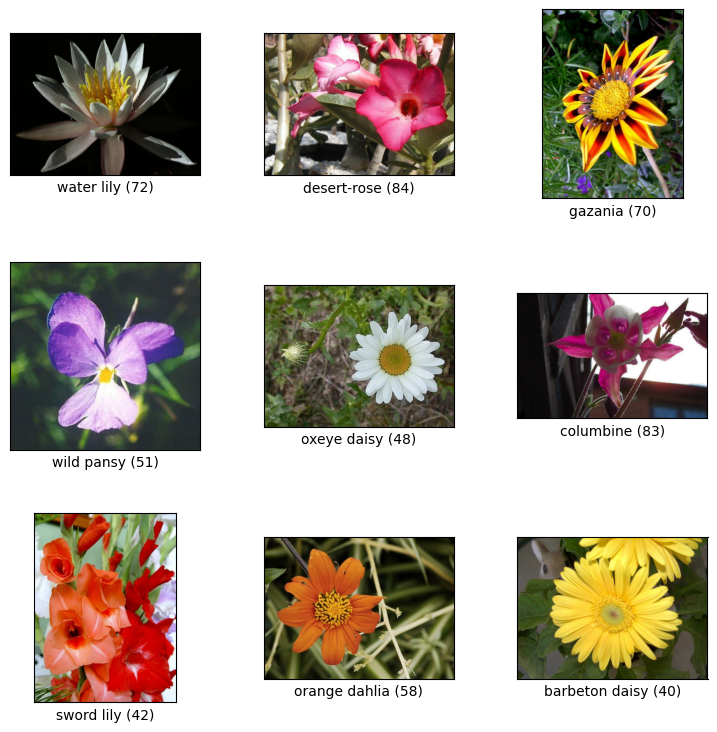

In [2]:
(train,test,valid),info = tfds.load(
        'oxford_flowers102',
        as_supervised=True,
        split=['train','test','validation'],
        with_info=True,
        data_dir='./datasets',
        shuffle_files=True
    )

fig = tfds.show_examples(train,info)

### Címkék Feldolgozása és Halmazok Megszámolása

In [3]:
labels = [ item.strip() for item in open('./datasets/oxford_flowers102/2.1.1/label.labels.txt','r').readlines() ]
num_of_labels = len(labels)

num_training_examples = train.cardinality().numpy()
num_validation_examples = valid.cardinality().numpy()
num_test_examples = test.cardinality().numpy()

### Bemenet Feldolgozása

In [4]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255.0, label

def augment(image, label):
  new_width = new_height = 224
  image = tf.image.resize(image, (new_width, new_height))/255.0
  return image, label

BATCH_SIZE = 32
train_batches = train.cache().shuffle(num_training_examples//4).map(augment).batch(BATCH_SIZE).prefetch(1)
validation_batches = valid.cache().map(augment).batch(BATCH_SIZE).prefetch(1)
test_batches = test.cache().map(augment).batch(BATCH_SIZE).prefetch(1)

### TensorBoard Beállítása

In [6]:
from tensorflow.keras.callbacks import TensorBoard
import time

NAME = "oxfordflower_InceptionV3_{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir=f'logs/{NAME}',
                          histogram_freq=1,
                          write_graph=True,
                          write_images=True)


### Modell Elkészítése
TensorFlowHub-ról töltjük le az előre tanított modelleket

In [7]:
URL = "https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5"
feature_extractor = hub.KerasLayer(URL,input_shape=(224, 224, 3))
feature_extractor.trainable = False

model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(info.features['label'].num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(train_batches, epochs=8, verbose=1, callbacks=[tensorboard])

Epoch 1/8


c:\Users\Nagy Antal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


32/32 [==============================] - 59s 2s/step - loss: 3.3470 - accuracy: 0.3480
Epoch 2/8
32/32 [==============================] - 53s 2s/step - loss: 0.6009 - accuracy: 0.9049
Epoch 3/8
32/32 [==============================] - 53s 2s/step - loss: 0.2060 - accuracy: 0.9833
Epoch 4/8
32/32 [==============================] - 57s 2s/step - loss: 0.1034 - accuracy: 1.0000
Epoch 5/8
32/32 [==============================] - 56s 2s/step - loss: 0.0640 - accuracy: 1.0000
Epoch 6/8
32/32 [==============================] - 53s 2s/step - loss: 0.0460 - accuracy: 1.0000
Epoch 7/8
32/32 [==============================] - 53s 2s/step - loss: 0.0352 - accuracy: 1.0000
Epoch 8/8
32/32 [==============================] - 57s 2s/step - loss: 0.0284 - accuracy: 1.0000


### Modell Mentése

- TensorFlow Model osztályából kell használni a .save metódust
- Így a KerasLayer megmarad

In [8]:
model.save('./models/BOARDED_'+NAME)

INFO:tensorflow:Assets written to: ./models/BOARDED_oxfordflower_InceptionV3_1683568559\assets


INFO:tensorflow:Assets written to: ./models/BOARDED_oxfordflower_InceptionV3_1683568559\assets


### Modell Betöltése
- Kész modell betöltése
- Tesztek futtatása
- Tesztek vizualizációja

` custom_objects={'KerasLayer': hub.KerasLayer} ` - 'hub.KerasLayer' betöltését engedélyezi

#### Ha friss modellt akar teszetlni

In [11]:
model = tf.keras.models.load_model(
  './models/BOARDED_'+NAME,
  custom_objects={'KerasLayer': hub.KerasLayer})

model.evaluate(validation_batches)

c:\Users\Nagy Antal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


32/32 [==============================] - 44s 1s/step - loss: 0.3906 - accuracy: 0.9069


[0.3906489908695221, 0.906862735748291]

#### Ha meglévő modellt akar tesztelni

In [5]:
model = tf.keras.models.load_model(
  ".\models\BOARDED_oxfordflower_InceptionV3_1683568559",
  custom_objects={'KerasLayer': hub.KerasLayer})

model.evaluate(validation_batches)

c:\Users\Nagy Antal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


32/32 [==============================] - 42s 1s/step - loss: 0.3906 - accuracy: 0.9069


[0.3906489908695221, 0.906862735748291]

### Betöltött Modell Tesztelése
- Zöld a jó
- Piros a rossz

1/1 [==============================] - 2s 2s/step


<Figure size 1000x900 with 0 Axes>

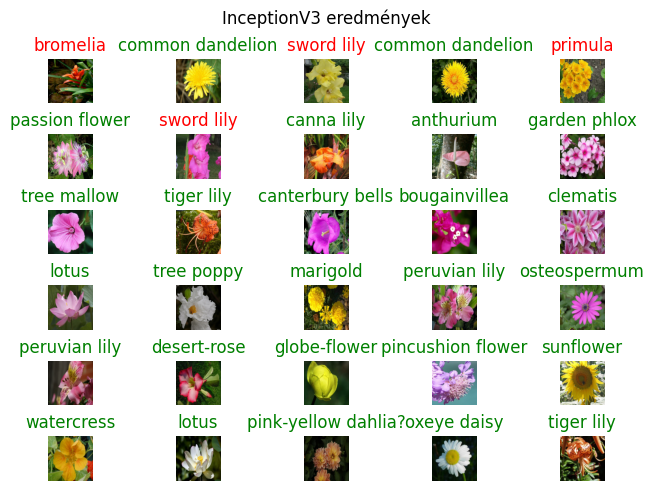

In [6]:
### Predict-hez adatok előkészítése ###
test = valid.cache().shuffle(num_training_examples//4).map(augment).batch(30).prefetch(1)
img, label = next(iter(test.take(1)))
tmp = model.predict(img.numpy())
res = tf.argmax(tmp, axis=1)

plt.figure(figsize=(10,9))
plt.subplots(6,5, constrained_layout=True)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(img[n])
    color = "green" if res[n] == label[n] else "red"
    plt.title(labels[label[n]], color=color)
    plt.axis('off')
    _ = plt.suptitle("InceptionV3 eredmények")